In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
from skimage import exposure, filters, morphology
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set paths
INPUT_IMAGE_PATH = r"E:\IRP_dataset_new\APTOS_combined_images"
OUTPUT_IMAGE_PATH = r"E:\IRP_dataset_new\IRP_combined_processed_images"
LABELS_PATH = r"E:\IRP_dataset_new\APTOS_labels_combined.csv"

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_IMAGE_PATH):
    os.makedirs(OUTPUT_IMAGE_PATH)
    print(f"Created output directory: {OUTPUT_IMAGE_PATH}")

Created output directory: E:\IRP_dataset_new\IRP_combined_processed_images


In [3]:
# Load labels
df = pd.read_csv(LABELS_PATH)
print(f"Loaded labels file with {len(df)} records")

Loaded labels file with 10832 records


In [4]:
# Function to detect eyeball and create circular mask
def create_circular_mask(image):
    """
    Detects the eyeball region and creates a circular mask
    """
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Normalize and convert to uint8
    normalized = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    gray_uint8 = np.uint8(normalized)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray_uint8, (7, 7), 0)
    
    # Threshold to create a binary image - using Otsu's method
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours are found, use a default circle
    if not contours:
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        radius = min(w, h) // 2 - 10
    else:
        # Find the largest contour - likely to be the eyeball
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get the minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        center = (int(x), int(y))
        radius = int(radius)
    
    # Create a circular mask
    mask = np.zeros_like(gray_uint8)
    cv2.circle(mask, center, radius, 255, -1)
    
    return mask

In [5]:
# Preprocessing function
def preprocess_fundus_image(image):
    """
    Apply a series of preprocessing techniques to enhance fundus image features:
    1. Circular masking
    2. CLAHE for contrast enhancement
    3. Unsharp masking for edge enhancement
    4. Color balance adjustment
    """
    # Ensure image is in BGR (OpenCV default)
    if image.dtype != np.uint8:
        image = np.uint8(image)
    
    # Make a copy of the original image
    original = image.copy()
    
    # Create circular mask
    mask = create_circular_mask(image)
    mask_3channel = cv2.merge([mask, mask, mask])
    
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(original, original, mask=mask)
    
    # Split into color channels
    b, g, r = cv2.split(masked_image)
    
    # Apply CLAHE to each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    r_clahe = clahe.apply(r)
    g_clahe = clahe.apply(g)
    b_clahe = clahe.apply(b)
    
    # Merge the CLAHE enhanced channels
    enhanced_image = cv2.merge([b_clahe, g_clahe, r_clahe])
    
    # Unsharp masking for edge enhancement
    gaussian = cv2.GaussianBlur(enhanced_image, (0, 0), 3.0)
    unsharp_image = cv2.addWeighted(enhanced_image, 1.5, gaussian, -0.5, 0)
    
    # Apply color balance adjustment (focus on green channel)
    b, g, r = cv2.split(unsharp_image)
    g = cv2.addWeighted(g, 1.2, np.zeros_like(g), 0, 0)  # Enhance green channel
    color_balanced = cv2.merge([b, g, r])
    
    # Final cleanup - ensure the background outside the mask is black
    processed_image = cv2.bitwise_and(color_balanced, color_balanced, mask=mask)
    
    return processed_image

In [6]:
# Function to demonstrate preprocessing on a single sample image
def demonstrate_preprocessing():
    """
    Pick a random image, apply preprocessing, and display before/after comparison
    """
    # Pick a random image
    all_images = os.listdir(INPUT_IMAGE_PATH)
    sample_image_name = random.choice(all_images)
    
    # Load the image
    img_path = os.path.join(INPUT_IMAGE_PATH, sample_image_name)
    original = cv2.imread(img_path)
    
    if original is None:
        print(f"Error loading image: {img_path}")
        return
    
    # Convert to RGB for display
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Apply preprocessing
    processed = preprocess_fundus_image(original)
    processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
    
    # Get image ID code (filename without extension)
    id_code = os.path.splitext(sample_image_name)[0]
    
    # Look up diagnosis if available
    diagnosis = "Unknown"
    if id_code in df['id_code'].values:
        diagnosis = df[df['id_code'] == id_code]['diagnosis'].values[0]
        diagnosis = "No DR" if diagnosis == 0 else "DR Positive"
    
    # Display the comparison
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title(f"Original Image\nID: {id_code}, Class: {diagnosis}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_rgb)
    plt.title("Processed Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('preprocessing_demo.png')
    plt.show()
    
    return id_code, original_rgb, processed_rgb

In [7]:
# Function to process a single image
def process_single_image(image_file):
    """
    Process a single image and save it to the output directory
    """
    img_path = os.path.join(INPUT_IMAGE_PATH, image_file)
    output_path = os.path.join(OUTPUT_IMAGE_PATH, image_file)
    
    # Skip if output already exists
    if os.path.exists(output_path):
        return None
    
    # Load image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error loading image: {img_path}")
        return None
    
    # Apply preprocessing
    processed = preprocess_fundus_image(image)
    
    # Save processed image
    cv2.imwrite(output_path, processed)
    
    return image_file

In [8]:
# Function to process the entire dataset
def process_all_images():
    """
    Process all images in the dataset using multithreading
    """
    print("Processing the entire dataset...")
    
    # Get all image files
    all_images = os.listdir(INPUT_IMAGE_PATH)
    total_images = len(all_images)
    
    print(f"Found {total_images} images. Starting preprocessing...")
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(process_single_image, all_images), total=total_images))
    
    # Count processed images
    processed_count = sum(1 for result in results if result is not None)
    print(f"Processed {processed_count} images. Results saved to {OUTPUT_IMAGE_PATH}")

In [9]:
# Function to compare original and processed images
def compare_random_images(num_samples=5):
    """
    Compare random original and processed images side by side
    """
    # Get list of processed images
    processed_images = os.listdir(OUTPUT_IMAGE_PATH)
    
    # Ensure we have some processed images
    if not processed_images:
        print("No processed images found. Run process_all_images() first.")
        return
    
    # Pick random samples
    sample_size = min(num_samples, len(processed_images))
    samples = random.sample(processed_images, sample_size)
    
    # Create a figure for comparison
    fig, axes = plt.subplots(sample_size, 2, figsize=(12, 4*sample_size))
    
    for i, img_file in enumerate(samples):
        # Load original and processed images
        original_path = os.path.join(INPUT_IMAGE_PATH, img_file)
        processed_path = os.path.join(OUTPUT_IMAGE_PATH, img_file)
        
        original = cv2.imread(original_path)
        processed = cv2.imread(processed_path)
        
        if original is None or processed is None:
            print(f"Error loading image pair: {img_file}")
            continue
        
        # Convert to RGB for display
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        
        # Get image ID code (filename without extension)
        id_code = os.path.splitext(img_file)[0]
        
        # Look up diagnosis if available
        diagnosis = "Unknown"
        if id_code in df['id_code'].values:
            diagnosis = df[df['id_code'] == id_code]['diagnosis'].values[0]
            diagnosis = "No DR" if diagnosis == A0 else "DR Positive"
        
        # Display images
        axes[i, 0].imshow(original_rgb)
        axes[i, 0].set_title(f"Original - ID: {id_code}\nClass: {diagnosis}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(processed_rgb)
        axes[i, 1].set_title("Processed")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('comparison_samples.png')
    plt.show()


In [10]:
# Function to analyze and visualize the green channel enhancement
def analyze_green_channel_enhancement():
    """
    Analyze the enhancement of the green channel, which is most important for DR detection
    """
    # Pick a random image
    all_images = os.listdir(INPUT_IMAGE_PATH)
    sample_image_name = random.choice(all_images)
    
    # Load the image
    img_path = os.path.join(INPUT_IMAGE_PATH, sample_image_name)
    original = cv2.imread(img_path)
    
    if original is None:
        print(f"Error loading image: {img_path}")
        return
    
    # Process the image
    processed = preprocess_fundus_image(original)
    
    # Extract green channels
    _, original_g, _ = cv2.split(original)
    _, processed_g, _ = cv2.split(processed)
    
    # Create histograms
    hist_original = cv2.calcHist([original_g], [0], None, [256], [0, 256])
    hist_processed = cv2.calcHist([processed_g], [0], None, [256], [0, 256])
    
    # Plot the images and histograms
    plt.figure(figsize=(15, 10))
    
    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    # Original green channel
    plt.subplot(2, 3, 2)
    plt.imshow(original_g, cmap='green')
    plt.title("Original Green Channel")
    plt.axis('off')
    
    # Original histogram
    plt.subplot(2, 3, 3)
    plt.plot(hist_original, color='green')
    plt.title("Original Green Channel Histogram")
    plt.xlim([0, 256])
    plt.grid(alpha=0.5)
    
    # Processed image
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image")
    plt.axis('off')
    
    # Processed green channel
    plt.subplot(2, 3, 5)
    plt.imshow(processed_g, cmap='green')
    plt.title("Enhanced Green Channel")
    plt.axis('off')
    
    # Processed histogram
    plt.subplot(2, 3, 6)
    plt.plot(hist_processed, color='green')
    plt.title("Enhanced Green Channel Histogram")
    plt.xlim([0, 256])
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('green_channel_analysis.png')
    plt.show()

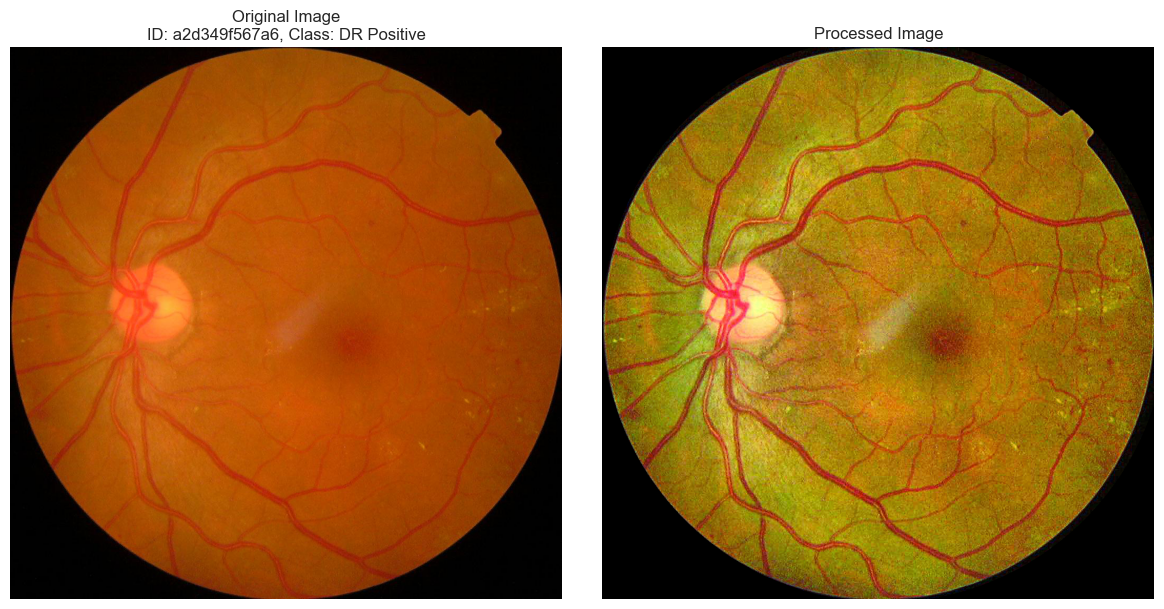

In [11]:
# Demonstrate preprocessing on a sample image
sample_id, original_sample, processed_sample = demonstrate_preprocessing()

In [13]:
process_all_images()

Processing the entire dataset...
Found 10832 images. Starting preprocessing...


100%|██████████| 10832/10832 [58:35<00:00,  3.08it/s]  

Processed 10832 images. Results saved to E:\IRP_dataset_new\IRP_combined_processed_images


In [15]:
# Simple script to check if Excel IDs exist in image folder
import os
import pandas as pd
import glob

# Define paths
COMBINED_IMAGES_PATH = r"E:\IRP_dataset_new\IRP_combined_processed_images"
COMBINED_LABELS_PATH = r"E:\IRP_dataset_new\APTOS_labels_combined.csv"

# Extensions to check
extensions = ['.png', '.jpg', '.jpeg', '.tif', '.tiff']

print("Simple ID Verification")
print("=" * 30)

# Read the Excel file
print("Reading Excel file...")
df = pd.read_csv(COMBINED_LABELS_PATH)
excel_ids = df['id_code'].tolist()
print(f"Found {len(excel_ids)} IDs in Excel file")

# Get all image files in the directory
print("Scanning image directory...")
all_images = []
for ext in extensions:
    images = glob.glob(os.path.join(COMBINED_IMAGES_PATH, f"*{ext}"))
    all_images.extend(images)

# Extract IDs from image filenames
image_ids = [os.path.splitext(os.path.basename(img))[0] for img in all_images]
print(f"Found {len(image_ids)} images in directory")

# Find IDs in Excel that don't have images
missing_images = []
for excel_id in excel_ids:
    if excel_id not in image_ids:
        missing_images.append(excel_id)

print(f"\nFound {len(missing_images)} IDs in Excel without corresponding images")
if missing_images:
    print("First 10 missing IDs:")
    for missing_id in missing_images[:10]:
        print(f"  {missing_id}")
    
    # Option to save missing IDs to file
    print("\nDo you want to save the complete list of missing IDs to a file? (yes/no)")
    save_option = input().strip().lower()
    if save_option == 'yes':
        output_path = r"E:\IRP_dataset_new\missing_ids.csv"
        pd.DataFrame({'id_code': missing_images}).to_csv(output_path, index=False)
        print(f"Saved missing IDs to {output_path}")

# Find images that don't have IDs in Excel
extra_images = []
for image_id in image_ids:
    if image_id not in excel_ids:
        extra_images.append(image_id)

print(f"\nFound {len(extra_images)} images without corresponding IDs in Excel")
if extra_images:
    print("First 10 extra images:")
    for extra_id in extra_images[:10]:
        print(f"  {extra_id}")
    
    # Option to save extra image IDs to file
    print("\nDo you want to save the complete list of extra image IDs to a file? (yes/no)")
    save_option = input().strip().lower()
    if save_option == 'yes':
        output_path = r"E:\IRP_dataset_new\extra_images.csv"
        pd.DataFrame({'id_code': extra_images}).to_csv(output_path, index=False)
        print(f"Saved extra image IDs to {output_path}")

print("\nVerification for processed image dataset complete!")

Simple ID Verification
Reading Excel file...
Found 10832 IDs in Excel file
Scanning image directory...
Found 10832 images in directory

Found 0 IDs in Excel without corresponding images

Found 0 images without corresponding IDs in Excel

Verification for processed image dataset complete!
